In [72]:
from collections import defaultdict
from pathlib import Path
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from train import train, train_cv
import data_processing as dp

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def kw2dict(**kwargs):
    return kwargs

def plot_train_test_err(trains, tests, train_errs, test_errs, x=None, figsize=None):
    plt.figure(figsize=figsize)
    tests = np.array(tests)
    trains = np.array(trains)
    test_errs = np.array(test_errs)
    train_errs = np.array(train_errs)
    if x is None:
        k = len(trains)
        x = np.array(range(k), dtype=np.int32)
    plt.plot(x, trains, label='train')
    plt.plot(x, tests, label='test')
    plt.fill_between(x, trains - train_errs, trains + train_errs, alpha=0.5)
    plt.fill_between(x, tests - test_errs, tests + test_errs, alpha=0.5)
    # plt.xticks(range(k))
    plt.yticks(np.arange(0.0, 1.01, 0.1))
    plt.legend()
    plt.grid()

In [65]:
FIGDIR = Path('figures')
os.makedirs(FIGDIR, exist_ok=True)

# Dataset Exploration

In [104]:
csv = train(return_csv=True, dailies_names=['locations', 'mobility'])

In [105]:
print('# Rows:', csv.shape[0])
print('# Participants:', csv.participant_id.unique().shape[0])

# Rows: 1161
# Participants: 285


Text(0.5, 14.722222222222216, 'Days Between Consecutive PHQ9 Tests')

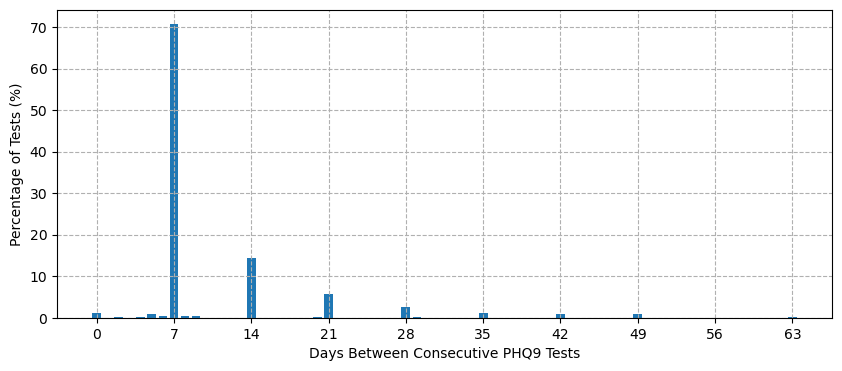

In [106]:
# how many days are there between consecutive PHQ9 tests in the same participants?
csv['date'] = pd.to_datetime(csv['date'])
date_diffs_g = csv.groupby('participant_id').apply(lambda x: x['date'] - x['date'].shift(1))
date_diffs = date_diffs_g.reset_index(drop=True).dropna()
day_diffs = date_diffs.dt.days
labels, counts = np.unique(day_diffs, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(labels, counts / np.sum(counts) * 100, align='center')
plt.gca().set_xticks(range(0, 64, 7))
plt.grid(linestyle='--')
plt.ylabel('Percentage of Tests (%)')
plt.savefig(FIGDIR / 'days_between_phq9.png', dpi=300, bbox_inches='tight')
plt.xlabel('Days Between Consecutive PHQ9 Tests')

Text(0.5, 36.72222222222221, '# Rows per Participant')

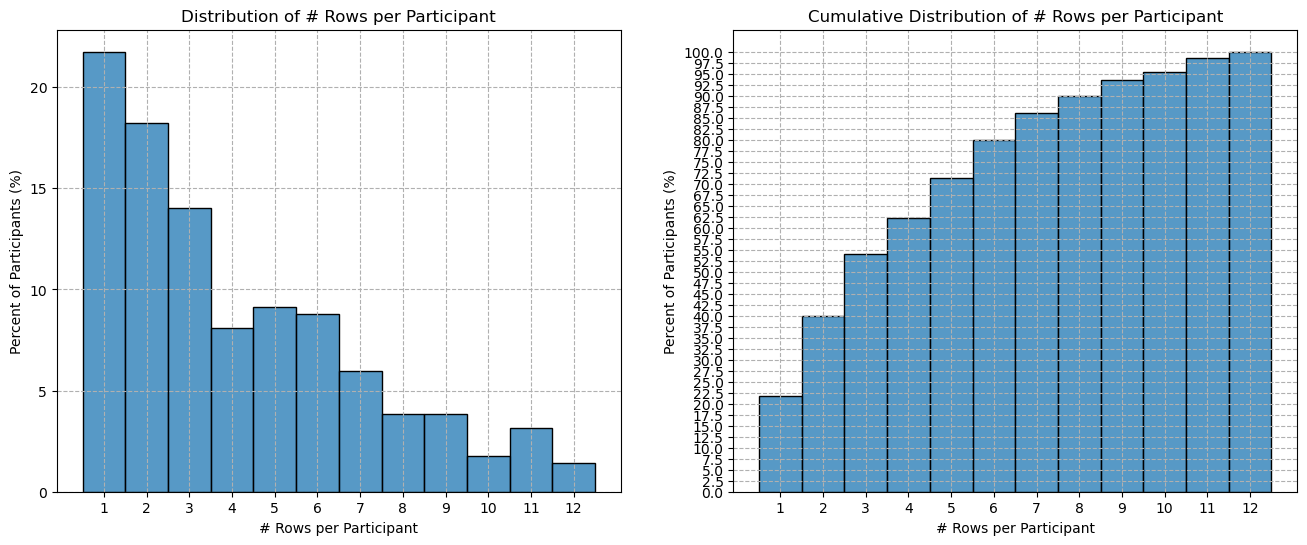

In [133]:
# Find the number of rows per participant
sizes = csv.groupby('participant_id').size()
_, axes = plt.subplots(1, 2, figsize=(16, 6))

plt.sca(axes[0])
sns.histplot(sizes, discrete=True, stat='percent', ax=plt.gca())
plt.grid(linestyle='--')
plt.xticks(range(1, 13))
plt.title('Distribution of # Rows per Participant')
plt.ylabel('Percent of Participants (%)')
plt.savefig(FIGDIR / 'numrows_per_participant.png', dpi=300, bbox_inches='tight')
plt.xlabel('# Rows per Participant')

plt.sca(axes[1])
sns.histplot(sizes, discrete=True, stat='percent', cumulative=True, ax=plt.gca())
plt.yticks(np.arange(0.0, 100.1, 2.5))
plt.grid(linestyle='--')
plt.xticks(range(1, 13))
plt.title('Cumulative Distribution of # Rows per Participant')
plt.ylabel('Percent of Participants (%)')
plt.savefig(FIGDIR / 'numrows_per_participant.png', dpi=300, bbox_inches='tight')
plt.xlabel('# Rows per Participant')

## Basic Regression with Random Forest & Different Splitting Methods

In [120]:
%%time
%%capture

results = {} # using RandomForestRegressor
base_kwargs = kw2dict(aggregate=True, TYPE='regression', N_SPLIT=10, dailies_names=['locations', 'phone'])
results['random_split'] = train_cv(SPLIT_BY_PARTICIPANT=False, **base_kwargs)
results['participant_split'] = train_cv(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, **base_kwargs)
results['personalized_k=1'] = train_cv(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1, **base_kwargs)
results['personalized_k=4'] = train_cv(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=4, **base_kwargs)

CPU times: user 58.8 s, sys: 5.94 s, total: 1min 4s
Wall time: 13.5 s


In [137]:
for k, r in results.items():
    print(k + ': ')
    for a, b in r.items():
        if a.endswith('score_mean'):
            print('   ', a, f'{b:.3f}')

random_split: 
    train_score_mean 0.907
    test_score_mean 0.408
participant_split: 
    train_score_mean 0.908
    test_score_mean -0.049
personalized_k=1: 
    train_score_mean 0.906
    test_score_mean 0.265
personalized_k=4: 
    train_score_mean 0.907
    test_score_mean 0.468


### A little check on location data

In [161]:
# how does the location data look?
loc_csv = dp.load_locations('data/df_location_ratio.csv')
loc_df = loc_csv.drop(['participant_id', 'date'], axis=1)
a = loc_df.sum(axis=0)
# plt.figure(figsize=(24, 6))
# sns.barplot(x=a.index, y=a.values, ax=plt.gca())
a.sort_values()
print('Average loc:', loc_df.sum(axis=1).mean())
(a / a.sum() * 100).sort_values(ascending=False)

Average loc: 0.4075881112857554


home                  93.012009
work                   4.377516
health                 0.566662
lodging                0.313589
dining_out             0.256980
repair                 0.199704
entertainment          0.168291
finance                0.168170
education              0.151022
supermarket            0.151022
home_store             0.140060
consumer_goods         0.113781
automotive             0.078972
transit                0.077801
personal_services      0.070923
government_offices     0.059706
place_of_worship       0.058985
park                   0.029958
place_of_mourning      0.004850
dtype: float64

## T-SNE

Visualizing colored T-SNE embeddings of the data to show that rows from the same participant cluster together.

In [109]:
from sklearn.manifold import TSNE
x = csv.drop(csv.columns.intersection(['participant_id', 'date', 'target']), axis=1).to_numpy()
y = csv.target.to_numpy().astype(np.int32)

In [110]:
%%time
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(x)

CPU times: user 12.8 s, sys: 5.38 s, total: 18.2 s
Wall time: 3.2 s


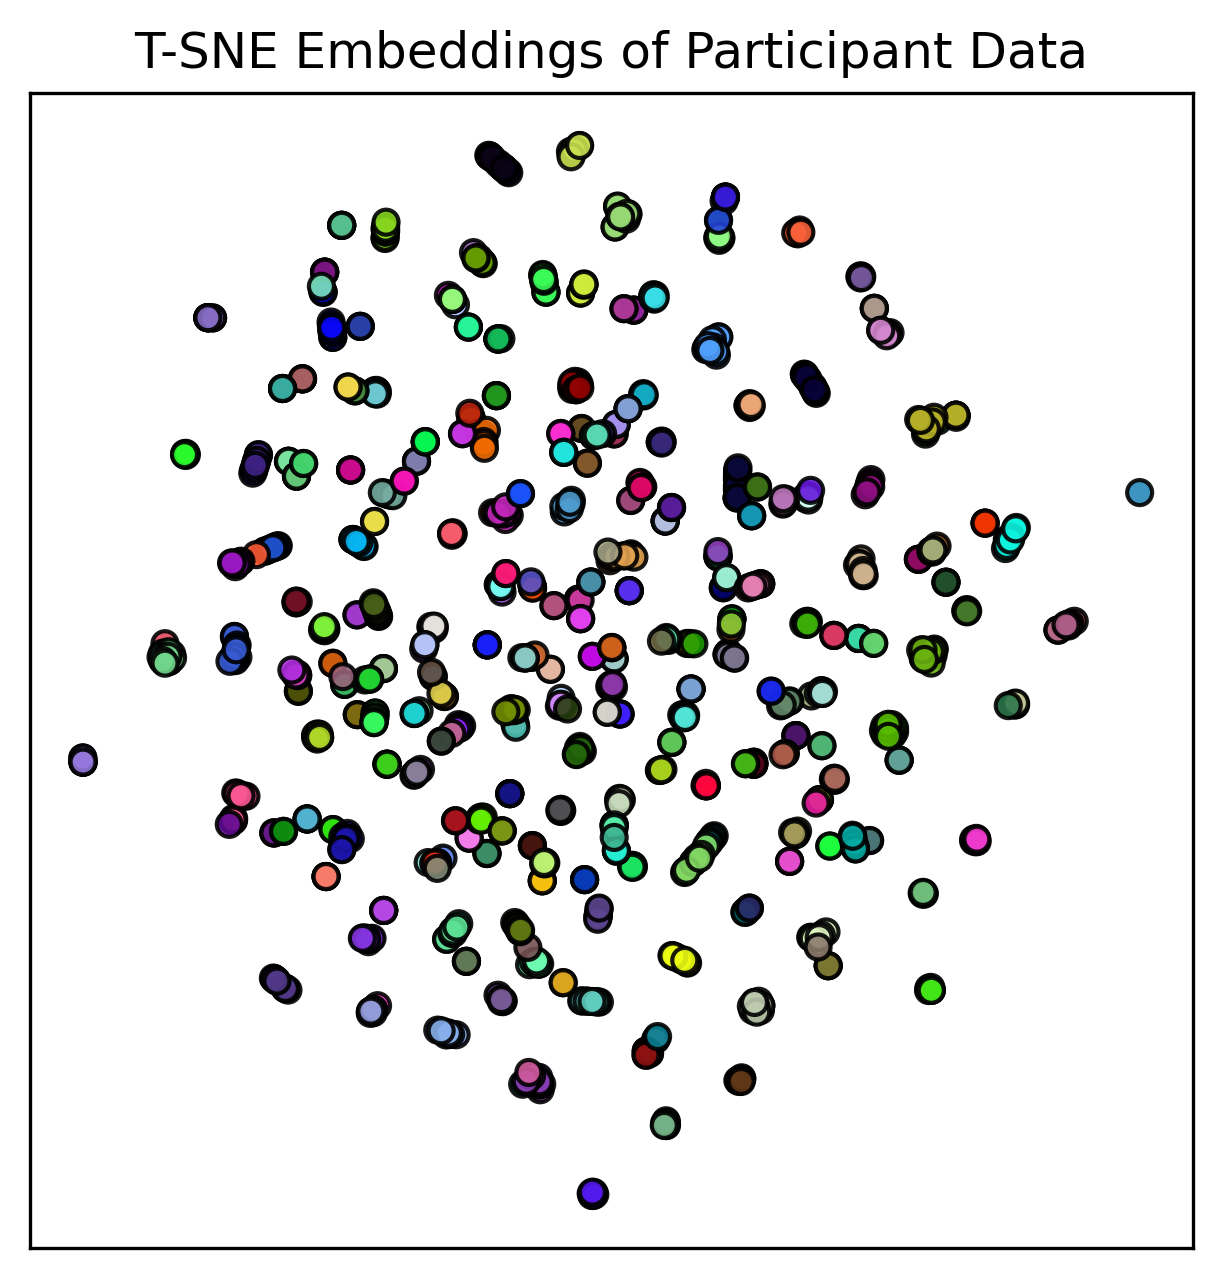

In [114]:
NUMBER_PARTICIPANTS = False # If True, put participant number on top circles, hard to read

# Assign random colors to each participant
n = len(x)
np.random.seed(433)
colors = np.empty((n, 3))
for pid in csv.participant_id.unique():
    mask = (csv.participant_id == pid).to_numpy()
    c = np.random.rand(1, 3)
    colors[mask] = c

# Scatterplot the embeddings
_, ax = plt.subplots(figsize=(5, 5), dpi=300)  
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=colors, cmap='gray', edgecolor='black', alpha=0.9)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

plt.savefig(FIGDIR / 'tsne.png', dpi=300, bbox_inches='tight')
plt.title('T-SNE Embeddings of Participant Data')

# Maybe add unique participant IDs too
if NUMBER_PARTICIPANTS:
    for i, pid in enumerate(csv.participant_id.unique()):
        inds, = np.where((csv.participant_id == pid).to_numpy())
        for j in inds:
            ax.annotate(i, (x_embedded[j, 0], x_embedded[j, 1]), fontsize=4, ha='center', va='center')
    


# Effect of Regularization

## Random Forest

In [143]:
%%time

rf_results = defaultdict(list)
max_depths = list(range(1, 65))
for d in tqdm(max_depths):
    m = train_cv(MODEL_TYPE='random-forest', SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1, aggregate=True, N_SPLIT=10,
                 model_kwargs=kw2dict(n_estimators=300, n_jobs=-1, random_state=433, max_depth=d))
    for k, v in m.items():
        rf_results[k].append(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [03:26<00:00,  3.23s/it]

CPU times: user 4min 34s, sys: 3min 12s, total: 7min 47s
Wall time: 3min 26s


Text(0.5, 14.722222222222216, 'Max Depth')

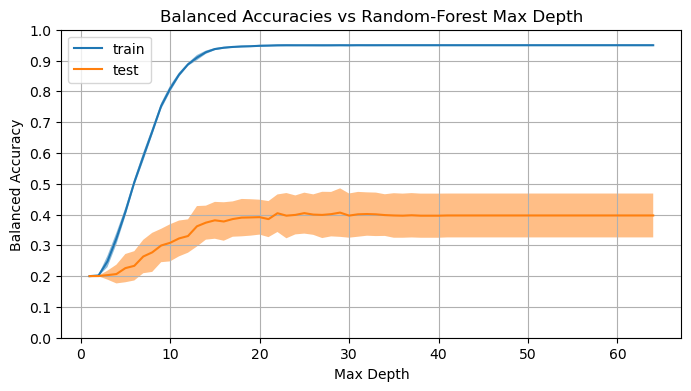

In [148]:
plot_train_test_err(rf_results['train_bal_mean'], rf_results['test_bal_mean'], 
                    rf_results['train_bal_std'], rf_results['test_bal_std'], x=max_depths, figsize=(8, 4))
plt.ylabel('Balanced Accuracy')
plt.savefig(FIGDIR / 'rf_reg.png', dpi=300, bbox_inches='tight')
plt.title('Balanced Accuracies vs Random-Forest Max Depth')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

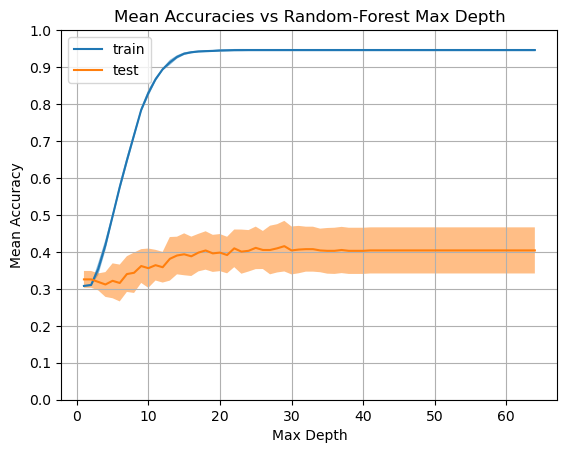

In [145]:
plot_train_test_err(rf_results['train_mean_mean'], rf_results['test_mean_mean'], 
                    rf_results['train_mean_std'], rf_results['test_mean_std'], x=max_depths)
plt.title('Mean Accuracies vs Random-Forest Max Depth')
plt.ylabel('Mean Accuracy')
plt.xlabel('Max Depth')

## XGBoost

In [149]:
%%time

results = defaultdict(list)
lambdas = np.logspace(-5, 5, 11)
for lambda_ in tqdm(lambdas):
    m = train_cv(MODEL_TYPE='xgboost', SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1, aggregate=True, N_SPLIT=10,
                 model_kwargs=kw2dict(n_estimators=100, reg_lambda=lambda_))
    for k, v in m.items():
        results[k].append(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [03:49<00:00, 20.86s/it]

CPU times: user 12min 54s, sys: 6min 31s, total: 19min 26s
Wall time: 3min 49s


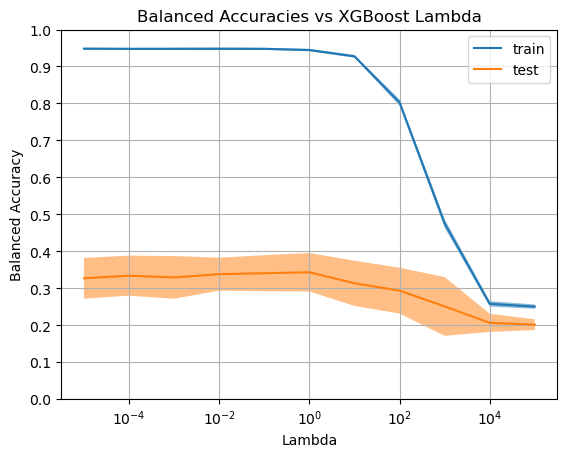

In [150]:
plot_train_test_err(results['train_bal_mean'], results['test_bal_mean'], 
                    results['train_bal_std'], results['test_bal_std'], x=lambdas)
plt.title('Balanced Accuracies vs XGBoost Lambda')
plt.ylabel('Balanced Accuracy')
plt.xlabel('Lambda')
plt.gca().set_xscale('log')

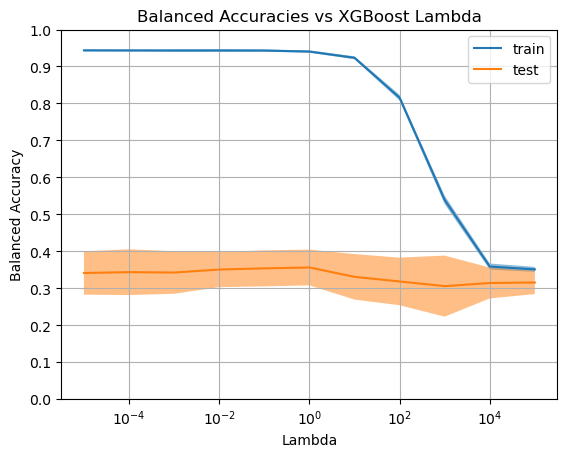

In [151]:
plot_train_test_err(results['train_mean_mean'], results['test_mean_mean'], 
                    results['train_mean_std'], results['test_mean_std'], x=lambdas)
plt.title('Balanced Accuracies vs XGBoost Lambda')
plt.ylabel('Balanced Accuracy')
plt.xlabel('Lambda')
plt.gca().set_xscale('log')

In [152]:
train_cv(MODEL_TYPE='mostfreq', SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1, aggregate=True, N_SPLIT=10)

{'train_bal_mean': 0.2,
 'train_bal_std': 0.0,
 'train_mean_mean': 0.30790188624162995,
 'train_mean_std': 0.001852124125820075,
 'test_bal_mean': 0.2,
 'test_bal_std': 0.0,
 'test_mean_mean': 0.32561071818962933,
 'test_mean_std': 0.022791753295315173}